In [2]:
from pycaret.clustering import *

import pyodbc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from random import randint

import warnings
warnings.filterwarnings("ignore")

In [ ]:
## Conexion al AS
""" cnxn = pyodbc.connect(
    driver='{iSeries Access ODBC Driver}',
    system='192.168.100.2',
    uid='TBLPRDUSR',
    pwd='bbbb')
cursor = cnxn.cursor() """
#cnxn.close()

#Cargue de la data desde el ERP de Dispapeles y se guarda en df
# cursor.execute('SELECT DSTCOD AS "Codigo distrito", VTAZNA AS "Codigo zona", VTANIT AS "Nit cliente", ((2022 - LEFT(MAX(VTAFCH),4)) * 12 ) + (6 - SUBSTRING(MAX(VTAFCH),5,2)) AS "Recency", SUM(A.VTAVLRVTA) AS "Monetary", COUNT( DISTINCT LEFT(VTAFCH, 6)) AS "Frequency" FROM SIDPRDDTA.VTAHEC A WHERE PRMCOD = 1 AND A.DSTCOD = 10 AND A.VTAZNA < 96 AND LEFT(VTAFCH,6) BETWEEN 202011 AND 202210 GROUP BY DSTCOD, VTAZNA, VTANIT')
# rows = cursor.fetchall()
# df = pd.DataFrame.from_records(rows, columns=[col[0] for col in cursor.description])

In [20]:
## Conexion al DWH
cnxn = pyodbc.connect(
    driver='{SQL Server}',
    server='192.168.100.58',
    uid='bilectura',
    pwd='D1sp@p3l3s')
cursor = cnxn.cursor()
#cnxn.close()

In [22]:
codigo_SQL = "SELECT A.DSTCOD AS 'Codigo distrito', B.VNDZNA AS 'Codigo zona actual', CONCAT(CONCAT(A.VTANIT,'-'),A.VTASUC) AS 'Nit cliente-sucursal', A.VTAANO AS 'Ano', A.VTAMES AS 'Mes', (((2021 - MAX(A.VTAANO)) * 12 ) + (0 - MAX(A.VTAMES))) * -1 AS 'Recency', SUM(A.VTAVLRVTA) AS 'Monetary', COUNT( DISTINCT A.VTAMES) AS 'Frequency' FROM V_VTA_VTAHEC A LEFT JOIN	DIM_CLIENTES B ON A.PRMCOD = B.PRMCOD AND A.DSTCOD = B.DSTCOD AND A.VTANIT = B.CLTNIT AND A.VTASUC = B.CLTSUC WHERE A.PRMCOD = 1 AND A.DSTCOD NOT IN (30,35) AND A.VTAZNA < 96 AND A.VTAFCH BETWEEN '2021-01-01' AND '2022-12-31' GROUP BY A.DSTCOD, B.VNDZNA, CONCAT(CONCAT(A.VTANIT,'-'),A.VTASUC),	A.VTAANO, A.VTAMES HAVING SUM(A.VTAVLRVTA) > 0"

In [21]:
#Cargue de la data desde el ERP de Dispapeles y se guarda en df
cursor.execute(codigo_SQL)
rows = cursor.fetchall()
df = pd.DataFrame.from_records(rows, columns=[col[0] for col in cursor.description])

In [6]:
maestra_zonas = pd.read_csv('C:/Users/tcardenas/OneDrive/OneDrive - Grupo DISPAPELES/Documents/Análisis clustering/Maestra_zonas.csv', delimiter= ";")

In [7]:
df["Monetary"] = df["Monetary"].astype(int)

In [8]:
df_2 = pd.merge(df, maestra_zonas, on= ["Codigo distrito", "Codigo zona actual"])

In [9]:
df_2["Nombre tipo zona"].unique()

array(['Artes graficas', 'TIG', 'Sector oficial', 'V Horeca',
       'Institucional', 'V SyE', 'No aplica', 'V Industria', 'Mayorista',
       'Gerencia', 'POS', 'Contact center', 'Dispacentro'], dtype=object)

In [10]:
list_filter = ['Artes graficas', 'V Horeca', 'Institucional', 'V SyE',
                'V Industria', 'Mayorista']

In [11]:
df = df_2[df_2["Nombre tipo zona"].isin(list_filter)]

In [12]:
df.describe()

,Codigo distrito,Codigo zona actual,Ano,Mes,Recency,Monetary,Frequency
count,123427.000000,123427.000000,123427.000000,123427.000000,123427.000000,1.234270e+05,123427.0
mean,40.382518,39.112407,2021.519684,6.574899,12.811103,7.214400e+06,1.0
std,23.561828,29.349128,0.499614,3.434475,6.921868,2.594012e+07,0.0
min,10.000000,1.000000,2021.000000,1.000000,1.000000,0.000000e+00,1.0
25%,20.000000,8.000000,2021.000000,4.000000,7.000000,3.048075e+05,1.0
50%,40.000000,60.000000,2022.000000,7.000000,13.000000,1.090535e+06,1.0
75%,60.000000,65.000000,2022.000000,10.000000,19.000000,4.400280e+06,1.0
max,90.000000,96.000000,2022.000000,12.000000,24.000000,1.355925e+09,1.0


In [44]:
df_3 = df.groupby(["Codigo distrito", "Nombre tipo zona", "Nit cliente-sucursal"]).agg({"Recency": np.max,
                                                                            "Monetary": np.sum,
                                                                            "Frequency": np.sum
                                                                            })
df_3 = df_3.reset_index(col_level= 1)
df_3

,Codigo distrito,Nombre tipo zona,Nit cliente-sucursal,Recency,Monetary,Frequency
0,10,Artes graficas,1010197660-1,14,2856739,1
1,10,Artes graficas,1010208977-1,1,1732800,1
2,10,Artes graficas,1012348815-1,2,78219,1
3,10,Artes graficas,1013637504-1,4,150045,1
4,10,Artes graficas,1013642113-1,24,5571618,1
...,...,...,...,...,...,...
14306,90,Mayorista,93300278-1,17,1990949,5
14307,90,Mayorista,93370623-1,24,19617604,23
14308,90,Mayorista,93386132-1,22,721928263,19
14309,90,Mayorista,93414007-1,24,18084903,15


In [45]:
#Se añade una key de Distrito-Nombretipozona para hacer mas facil la identificacion cuando se usa todo el pais
#Se genera la calificacion de Recency basado en los valores máximos
#Se divide por millón la columna Monetary para disminuir el rango de los valores
df_3['Distrito-Nombretipozona'] = df_3['Codigo distrito'].astype(str) + '-' + df_3['Nombre tipo zona']
df_3['Monetary'] = (df_3['Monetary'] / 1000).astype(int)
df_3['Frequency'] = (df_3['Frequency']).astype(int)

In [46]:
df_3.describe()

,Codigo distrito,Recency,Monetary,Frequency
count,14311.000000,14311.000000,1.431100e+04,14311.000000
mean,41.646496,18.902103,6.222100e+04,8.624345
std,23.956387,6.644301,2.959677e+05,7.910941
min,10.000000,1.000000,4.000000e+00,1.000000
25%,20.000000,15.000000,9.640000e+02,2.000000
50%,40.000000,22.000000,4.665000e+03,5.000000
75%,60.000000,24.000000,2.357950e+04,14.000000
max,90.000000,24.000000,1.513502e+07,24.000000


In [ ]:
df_random = df_3.sample(frac = 0.8, random_state= 42)

In [63]:
list_dtos = df_3["Distrito-Nombretipozona"].unique()


In [106]:
for n, dto in enumerate(list_dtos):
    # Creacion y auste del modelo por cada distrito-tipo de zona
    df_dto = df_3[df_3["Distrito-Nombretipozona"] == dto]
    df_x = df_dto[['Recency', 'Monetary', 'Frequency']].sort_values(by= ['Monetary','Recency', 'Frequency'])
    s = setup(df_x, normalize = False, verbose= False, preprocess= False)
    model_kmeans = create_model('kmeans', num_clusters= 5)
    df_pred_km = predict_model(model_kmeans, data = df_dto)
    
    # Reasignacion de los nombres de los clusters
    trans = df_pred_km.groupby(
                                    ["Cluster"]).agg({
                                                    "Recency": np.mean, "Monetary": np.mean, "Frequency": np.mean,
                                                    }).sort_values(
                                                                    by= ["Recency", "Frequency", "Monetary"],
                                                                    ascending= False
                                                                    ).reset_index()
    trans["Letra cluster"] = ["A", "B", "C", "D", "E"]
    trans = trans[["Cluster", "Letra cluster"]]
    df_pred_km = pd.merge(df_pred_km, trans, on= ["Cluster"])
    
    # Descargue del modelo
    df_pred_km.to_csv(f"C:/Users/tcardenas/OneDrive/OneDrive - Grupo DISPAPELES/Documents/Portafolio TCL Git/ML-TomasCaLo---Dispapeles/Clustering/Modelos 20-01-23/{n} Clustering 20-1-23 {dto}.csv",
                        encoding= 'utf-8', index= False)

,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.7761,3284.4376,0.3529,0,0,0


In [122]:
df_random = df_3.sample(frac = 0.8)
df_X = df_random[['Recency', 'Monetary', 'Frequency']].sort_values(by= ['Monetary','Recency', 'Frequency'])
s = setup(df_X, normalize = False, verbose= False, preprocess= False, numeric_features = ['Monetary','Recency', 'Frequency'], n_jobs= 10, silent=True)
model_kmeans = create_model('kmeans', num_clusters= 5)
df_pred_km = predict_model(model_kmeans, data = df_3)

,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.9052,32893.2071,0.4624,0,0,0


Text(0.5, 0, 'Frequency')

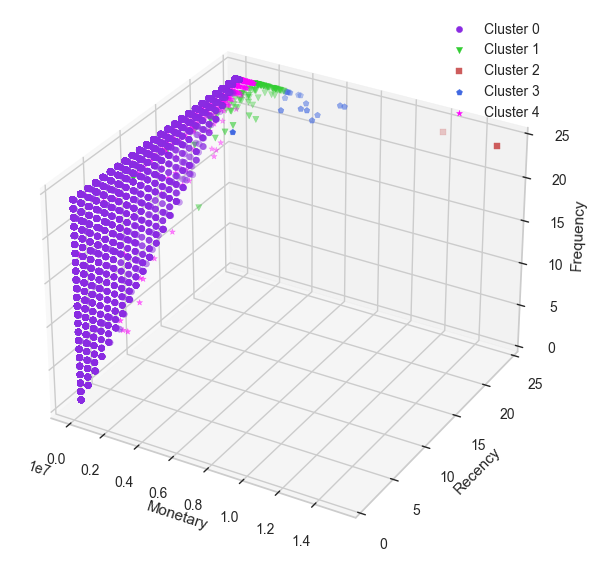

In [124]:
fig = plt.figure(figsize=(7,10))
ax = fig.gca(projection='3d')

m = ['o', 'v', 's', 'p', '*']
col =  ['blueviolet', 'limegreen', 'indianred', 'royalblue', 'magenta']
leg = ['Cluster 0','Cluster 1','Cluster 2','Cluster 3', 'Cluster 4']
cluster = list(np.unique(df_pred_km['Cluster']))

for c in range(5):
    df_plot = df_pred_km[df_pred_km['Cluster'] == cluster[c]]
    ax.scatter(df_plot['Monetary'],df_plot['Frequency'], df_plot['Recency'] , marker= m[c], c= col[c])
    
ax.legend(leg)
ax.set_xlabel('Monetary')
ax.set_ylabel('Recency')
ax.set_zlabel('Frequency')

In [125]:
plot_model(model_kmeans, plot = 'cluster')

In [ ]:
#Cambio de nombre de los cluster y orden basado en tamaños
df_pred_km = df_pred_km.replace(["Cluster 0", "Cluster 3", "Cluster 1", "Cluster 4", "Cluster 2"],["E", "D", "C", "B", "A"])

In [ ]:
plot_model(model_kmeans, plot = 'elbow')

In [ ]:
plot_model(model_kmeans, plot = 'distribution')

In [ ]:
plot_model(model_kmeans, plot = 'silhouette')

In [ ]:
plot_model(model_kmeans, plot = 'distance')

In [ ]:
save_model(model_kmeans, 'Model kmeans Version random 19-01-23')

In [ ]:
# saved_model =  load_model('Model Version random 9-11')

In [126]:
get_metrics(model_kmeans)

,Name,Display Name,Score Function,Scorer,Target,Args,Greater is Better,Needs Ground Truth,Custom
ID,,,,,,,,,
silhouette,Silhouette,Silhouette,<function silhouette_score at 0x0000023AED2C5D30>,make_scorer(silhouette_score),pred,{},True,False,False
chs,Calinski-Harabasz,Calinski-Harabasz,<function calinski_harabasz_score at 0x0000023...,make_scorer(calinski_harabasz_score),pred,{},True,False,False
db,Davies-Bouldin,Davies-Bouldin,<function davies_bouldin_score at 0x0000023AED...,make_scorer(davies_bouldin_score),pred,{},True,False,False
hs,Homogeneity Score,Homogeneity,<function homogeneity_score at 0x0000023AED28C...,make_scorer(homogeneity_score),pred,{},True,True,False
ari,Rand Index,Rand Index,<function adjusted_rand_score at 0x0000023AED2...,make_scorer(adjusted_rand_score),pred,{},True,True,False
cs,Completeness Score,Completeness,<function completeness_score at 0x0000023AED28...,make_scorer(completeness_score),pred,{},True,True,False


In [127]:
model_kmeans

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=5, n_init=10, n_jobs=10, precompute_distances='deprecated',
       random_state=6192, tol=0.0001, verbose=0)